In [29]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
import matplotlib.cm as cm
import sys
import os
import errno
import netCDF4 as nc
import glob
import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise
            
####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

a=6371.0e3
R=a

# c=5
# ncfile='/project2/tas1/pragallva/Summer_quarter_2019/exp_data/isca_repeat/HC0_la5m_oc5m/HC0_la5m_oc5m0.nc'
# v_var=nc.Dataset(ncfile,'r')
# sigma_full=v_var['pfull'][::-1]
# sigma_half=v_var['phalf'][::-1]
# lat_o=v_var['lat'][:]

In [30]:
ls /project2/tas1/pragallva/Summer_quarter_2019/post_process_data/am2_repeat/HC0_la50m_oc50m/

eddies_high_pass_freq_avg30.hkl  eddies_monthly_pass_freq_avg30.hkl
eddies_inter1_freq_avg30.hkl


In [31]:
def source(N=30, file='HC0_la5m_oc5m', FREQ='high', moment=1):
    momentum = '/project2/tas1/pragallva/Summer_quarter_2019/post_process_data/am2_repeat/'\
               +file+'/eddies_'+FREQ+'_freq_avg'+str(N)+'.hkl'
    if moment == 1:
       return load(momentum)#, load(stress)

storm_pos=load('/project2/tas1/pragallva/Summer_quarter_2019/post_process_data/am2_repeat/data_in_pres_coord/avged_over30days/storm_pos.hkl')

m5m_5m_H        =  source(FREQ='high_pass', file='HC0_la5m_oc5m')
m5m_5m_M        =  source(FREQ='monthly_pass',  file='HC0_la5m_oc5m')
m5m_5m_I        =  source(FREQ='inter1', file='HC0_la5m_oc5m')
# m5m_5m_I2     =  source(FREQ='inter2', file='HC0_la5m_oc5m')

m50m_50m_H     =  source(FREQ='high_pass', file='HC0_la50m_oc50m')
m50m_50m_M    =  source(FREQ='monthly_pass',  file='HC0_la50m_oc50m')
m50m_50m_I     =  source(FREQ='inter1', file='HC0_la50m_oc50m')
# m50m_50m_I2     =  source(FREQ='inter2', file='HC0_la50m_oc50m')


In [32]:
pwd

u'/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/am2/jupyter_notebooks'

In [33]:
exp_H      = [m5m_5m_H, m50m_50m_H]
exp_I      = [m5m_5m_I, m50m_50m_I]
exp_M      = [m5m_5m_M, m50m_50m_M]
exp_names  = ['m5m_5m', 'm50m_50m']

lat = exp_H[0]['lat']
lon = exp_H[0]['lon']
sigma_full = exp_H[0]['sigma_full']

In [34]:
def extract_data( FREQ='H', verbose=False):
    if FREQ  == 'H':
        exps = exp_H
    if FREQ  == 'M':
        exps = exp_M
    if FREQ  == 'I':
        exps = exp_I
        
    days = '_'+FREQ    
    
    for key, value in exps[0].items():
      if type(value)==type({}):
             for sub_key, sub_value in value.items():
                globals()[sub_key+str(days)]=[]
                if verbose == True :
                     print sub_key+str(days)
      else :    
                globals()[key+str(days)]=[]
                if verbose == True :
                     print key+str(days)
                                    
                
                        
    for d in range(len(exps)):
        for key, value in exps[d].items():
            if type(value)==type({}):
                for sub_key, sub_value in value.items():
                    globals()[sub_key+str(days)].append(sub_value)
            else :    
                    globals()[key+str(days)].append(value)  
                                        
                    
                    
    for key, value in exps[0].items():
      if type(value)==type({}):
             for sub_key, sub_value in value.items():
                globals()[sub_key+str(days)]=np.array(globals()[sub_key+str(days)])
      else :    
                globals()[key+str(days)]=np.array(globals()[key+str(days)])


In [35]:
extract_data(FREQ='H', verbose=True)
extract_data(FREQ='M')
extract_data(FREQ='I')

vert_EKE_flux_H
EMF_H
vert_EKE_H
avg_days_H
vert_sensible_flux_H
EKE_H
vert_potential_flux_H
lon_H
latent_flux_H
vert_latent_flux_H
sigma_full_H
potential_flux_H
frequency_H
vert_EMF_H
lat_H
EKE_flux_H
sensible_flux_H


In [36]:
EKE_H.shape

(2, 1741, 24, 12)

## Fields to be NS averaged with flux_fag 1##

In [37]:
def N_S_avg(TE, flux_flag=-1):
    MONL = TE.shape[-1]
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], MONL/2, axis=-1))/2.0  
    TE1= avg(TE)
    ap= lambda x: np.append(x,x[...,0,None],axis=-1)
    return ap(TE1), lat[l_N]

from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  MONL = flux.shape[-1]  
  D = np.zeros(((flux.shape[0]),(flux.shape[-1])))
  for d in range(0,len(exp_H)):
    for m in range(0,MONL):
            l_range=((lat>=30) & (lat<=60)) 
            X=storm_pos
            interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

In [38]:
factorv = (2*np.pi*np.cos(np.deg2rad(lat))*R)[None,:,None]#/10**15
factor = (2*np.pi*np.cos(np.deg2rad(lat))*R)[None,:,None,None]#/10**15

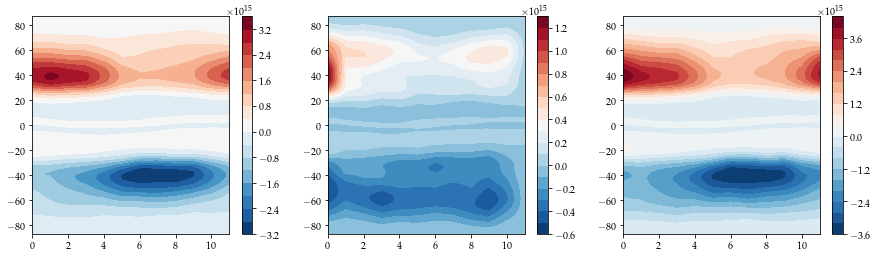

In [39]:
d=1; p=0
py.figure(figsize=(15,4))
py.subplot(1,3,1)
py.contourf(range(12),lat,(vert_sensible_flux_H*factorv)[d,:,:],20, cmap=cm.RdBu_r); py.colorbar()
py.subplot(1,3,2)
py.contourf(range(12),lat,(vert_sensible_flux_I*factorv)[d,:,:],20, cmap=cm.RdBu_r); py.colorbar()
py.subplot(1,3,3)
py.contourf(range(12),lat,(vert_sensible_flux_M*factorv)[d,:,:], 20,cmap=cm.RdBu_r); py.colorbar()

In [60]:
np.min(EKE_Ha)/10**6

4.433470452492398e-05

In [40]:
high=[sensible_flux_H, vert_sensible_flux_H,potential_flux_H,vert_potential_flux_H,latent_flux_H,vert_latent_flux_H ]
inter=[sensible_flux_I, vert_sensible_flux_I,potential_flux_I,vert_potential_flux_I,latent_flux_I,vert_latent_flux_I ]
monthly=[sensible_flux_M, vert_sensible_flux_M,potential_flux_M,vert_potential_flux_M,latent_flux_M,vert_latent_flux_M ]


EKE_Ha, lat_a = N_S_avg(EKE_H,1)
EKE_Ia, lat_a = N_S_avg(EKE_I,1)
vert_EKEa, lat_a = N_S_avg(vert_EKE_H,1)
vert_EKEIa, lat_a = N_S_avg(vert_EKE_M-vert_EKE_H,1)

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((div.shape[0],13))
  for d in range(0,div.shape[0]):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

def spher_div(x,fac=1):
       N=100
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(x.shape[0]):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat_a[:])) ),N)
       return div

dtheta=np.radians(lat_a[1]-lat_a[0])
def eddies_avg(Y=high):
    TEsens_a                         =  N_S_avg(Y[0]*factor,-1)[0]
    TEsensv_a                        =  N_S_avg(Y[1]*factorv,-1)[0]
    TEpot_a                          =  N_S_avg(Y[2]*factor,-1)[0]
    TEpotv_a                         =  N_S_avg(Y[3]*factorv,-1)[0]
    TEmoist_a                        =  N_S_avg(Y[4]*factor,-1)[0]
    TEmoistv_a,lat_a                 =  N_S_avg(Y[5]*factorv,-1)
    TE_a =  (TEsensv_a+TEpotv_a+TEmoistv_a)/10**15
    TEv_a = (TEsens_a+TEpot_a+TEmoist_a)/10**15    
    div_TE_a=spher_div(TE_a*10**15)

    return TE_a, div_TE_a


TE_H, div_TE_H  = eddies_avg(Y=high)
TE_I, div_TE_I  = eddies_avg(Y=inter)
TE_M, div_TE_M  = eddies_avg(Y=monthly)
storm_pos_H = find_zero(div_TE_H)
storm_pos_I = find_zero(div_TE_I)
storm_pos_M = find_zero(div_TE_M)

TE_I = TE_M - TE_H
div_TE_I = div_TE_M- div_TE_H

from scipy.interpolate import interp1d
def inerp_at_max(flux,lat):
  MONL = flux.shape[-1] 
  D = np.zeros(((flux.shape[0]),(flux.shape[-1])))
  for d in range(0,len(exp_H)):
    for m in range(0,MONL):
            l_range=((lat>=30) & (lat<=60)) 
            X=storm_pos
            interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
            try :
                D[d,m]=interpolation_function(X[d,m])
            except ValueError as err:
                D[d,m]==np.nan        
  return D

Ihigh  = inerp_at_max(flux=TE_H,lat=lat_a)
Iinter = inerp_at_max(flux=TE_I,lat=lat_a)
Itotal = inerp_at_max(flux=TE_I+TE_H,lat=lat_a)
Imonthly = inerp_at_max(flux=TE_M,lat=lat_a)
Ieke   = inerp_at_max(flux=vert_EKEa,lat=lat_a)

In [41]:
Ieke.shape

(2, 13)

In [42]:
def M(y):
    return y-y[:,:-1].mean(axis=-1)[:,None]

In [43]:
TE_MSE= np.load('/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/isca/jupyter_notebooks/TE_MSE_monthly.npy')
Intensity_monthly= \
np.load('/project2/tas1/pragallva/Summer_quarter_2019/codes/python_scripts/isca/jupyter_notebooks/Intensity_monthly.npy')

    

In [44]:
TE_MSE.shape

(2, 871, 13)

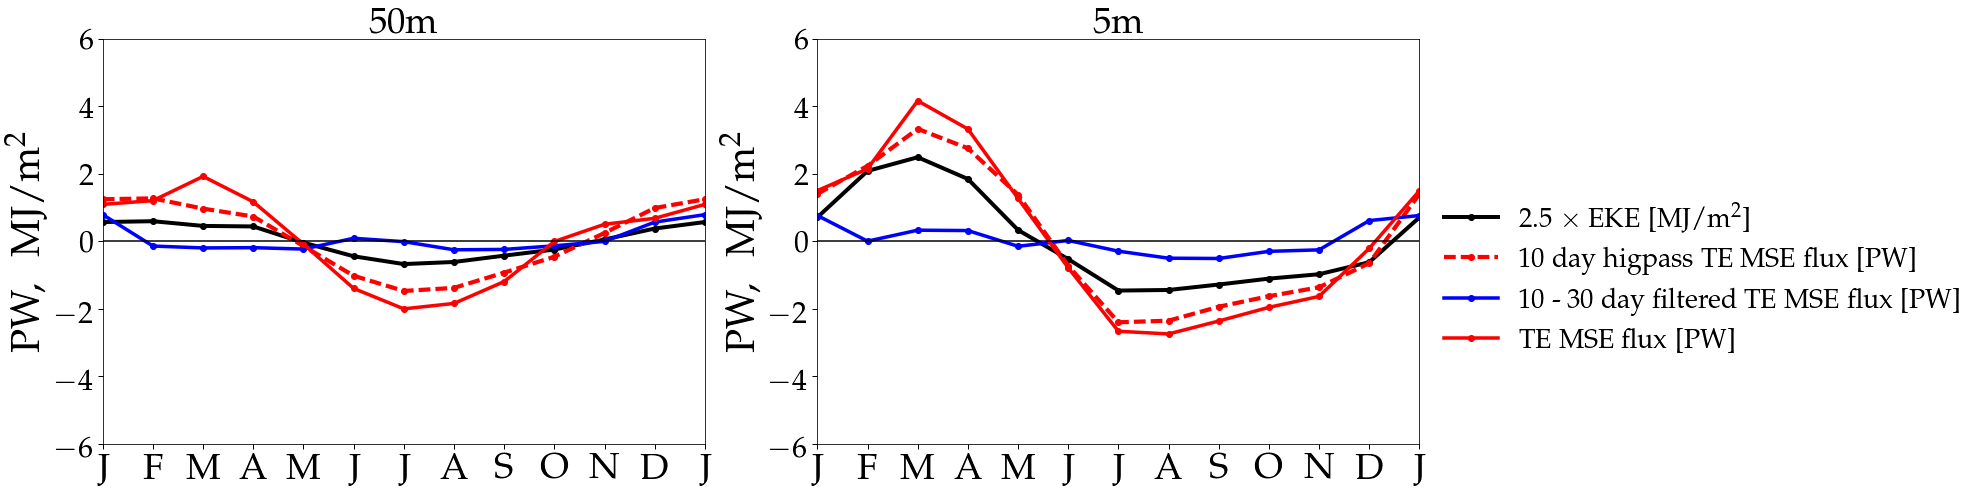

In [45]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']   
depths=['5m', '50m']
py.figure(figsize=(20,7))
i=0; l=6.2
for d in [1,0]:
    i=i+1
    py.subplot(1,2,i)
    py.plot(2.5*M(Ieke)[d,:]/10**6, 'ko-', label=r'2.5 $\times$ EKE [MJ/m$^2$]',lw=4.0)
    py.plot(M(Ihigh)[d,:],        'ro--',  label=r'10 day higpass TE MSE flux [PW]',lw=4.2)
    py.plot(M(Iinter)[d,:],      'bo-',  label=r'10 - 30 day filtered TE MSE flux [PW]',lw=3.5)
#     py.plot(M(Imonthly)[d,:],    'ro-',   label=r'30-day highpass TE MSE flux [PW]',lw=3.5)
    py.plot(M(Intensity_monthly)[d,:], 'ro-',   label=r'TE MSE flux [PW]',lw=3.5)
#     py.plot(M(Itotal)[d,:], 'yo-',   label=r'sum [PW]',lw=3.5)

    py.ylim(-6,6)
    py.tick_params(labelsize=18,size=4,width=2)
    py.ylabel(r'PW,$\:\:$  MJ/m$^2$',fontsize=40)
    py.tick_params(labelsize=30,size=5,width=1)
    py.xticks(range(13), mticks,size=37)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
    py.xlim(0,12)
    py.axhline(0,color='k')
    if d==0:
        py.legend(loc='best', fontsize=27,frameon=False, bbox_to_anchor=(1, 0.65),)
    py.title(str(depths[d]),fontsize=37)
    py.tight_layout()
source= "/project2/tas1/pragallva/Winter_quarter_2019/codes/python_scripts/miscellaneous/Paper_figures_ISCA/Sep16/"
py.savefig('Sep23_Figures/EKE_monTE_highTE.pdf',bbox_inches='tight')

In [46]:
# d=0
# py.plot(5*M(Ieke)[d,:]/10**6, 'ko-')
# py.plot(M(Ihigh)[d,:],      'ro--')
# py.plot(M(Intensity_monthly)[d,:],      'ro-')
# py.axhline(0)

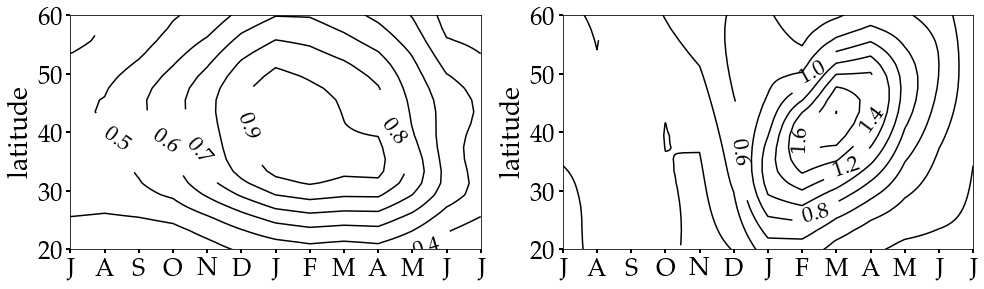

In [47]:
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 8
# loc=loc-1

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(vert_EKEa[d,:,:]/10**6),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
#py.title('10 day high pass filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(vert_EKEa[d,:,:]/10**6),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
#py.title(r'10 day high pass filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

# py.savefig('Sep16_Figures/10_day_highpass_filtered_EKE.pdf')

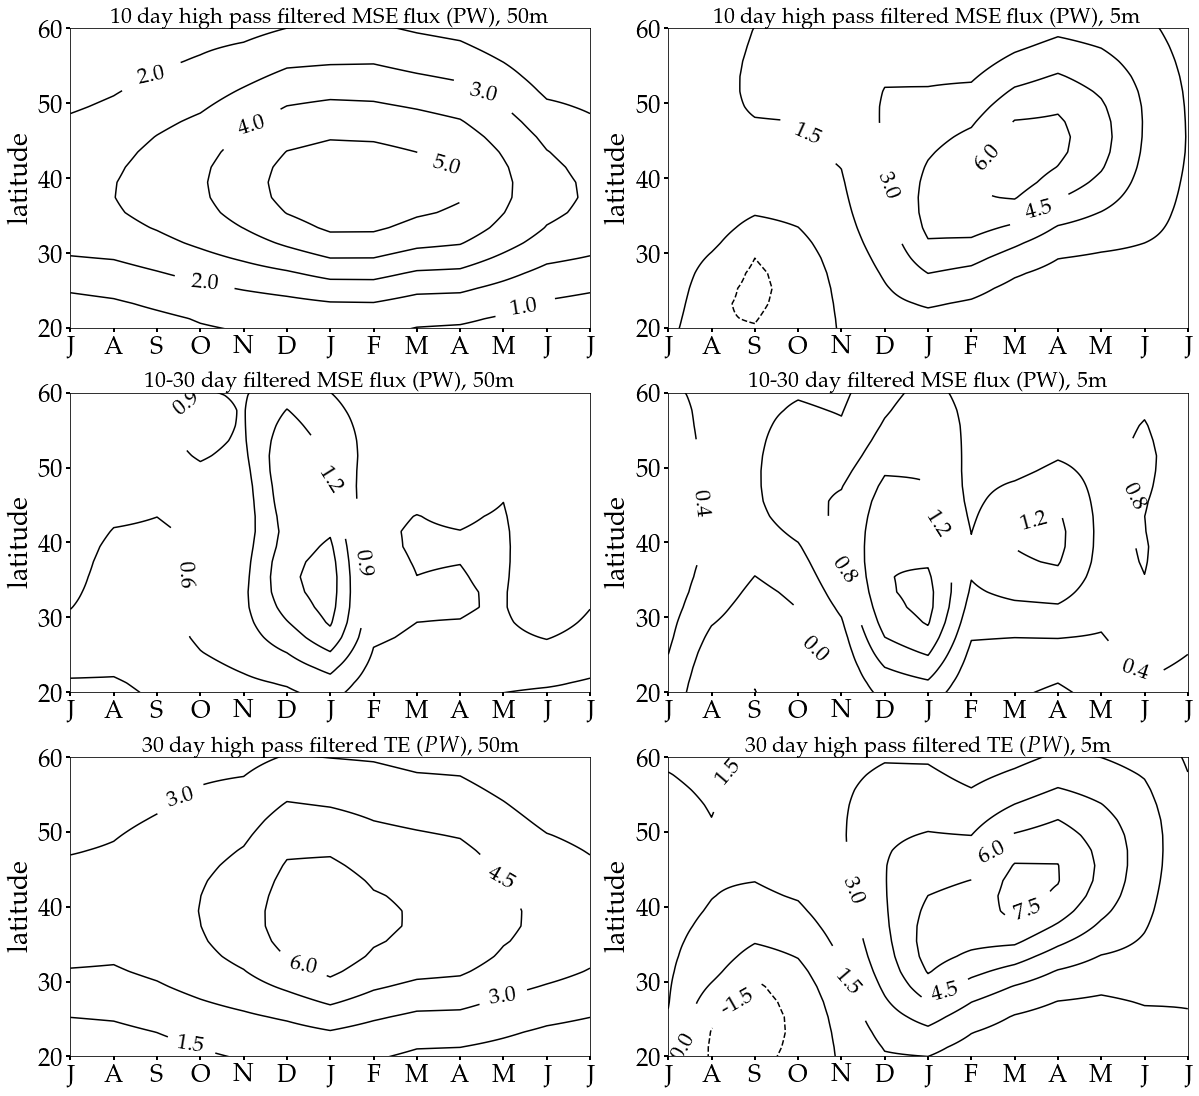

In [48]:
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(TE_H[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('10 day high pass filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(TE_H[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10 day high pass filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=1
py.subplot(5,3,4)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll((TE_I)[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('10-30 day filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,5)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll((TE_I)[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
py.tight_layout()


d=1
py.subplot(5,3,7)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll((TE_I+TE_H)[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'30 day high pass filtered TE ($PW$),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

d=0
loc=22
n=0;
py.subplot(5,3,8)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll((TE_I+TE_H)[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'30 day high pass filtered TE ($PW$), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
py.tight_layout()

#py.savefig('Sep16_Figures/high_filtered_TE.pdf')

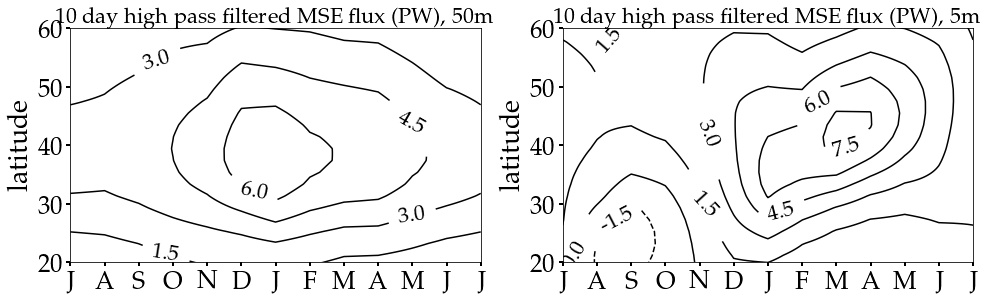

In [61]:
sumi  = TE_H + TE_I
mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1
d=0
loc=22
n=0;
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10 day high pass filtered MSE flux (PW), '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=1
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title('10 day high pass filtered MSE flux (PW),  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

In [66]:
vert_EKEa

(2, 871, 24, 13)

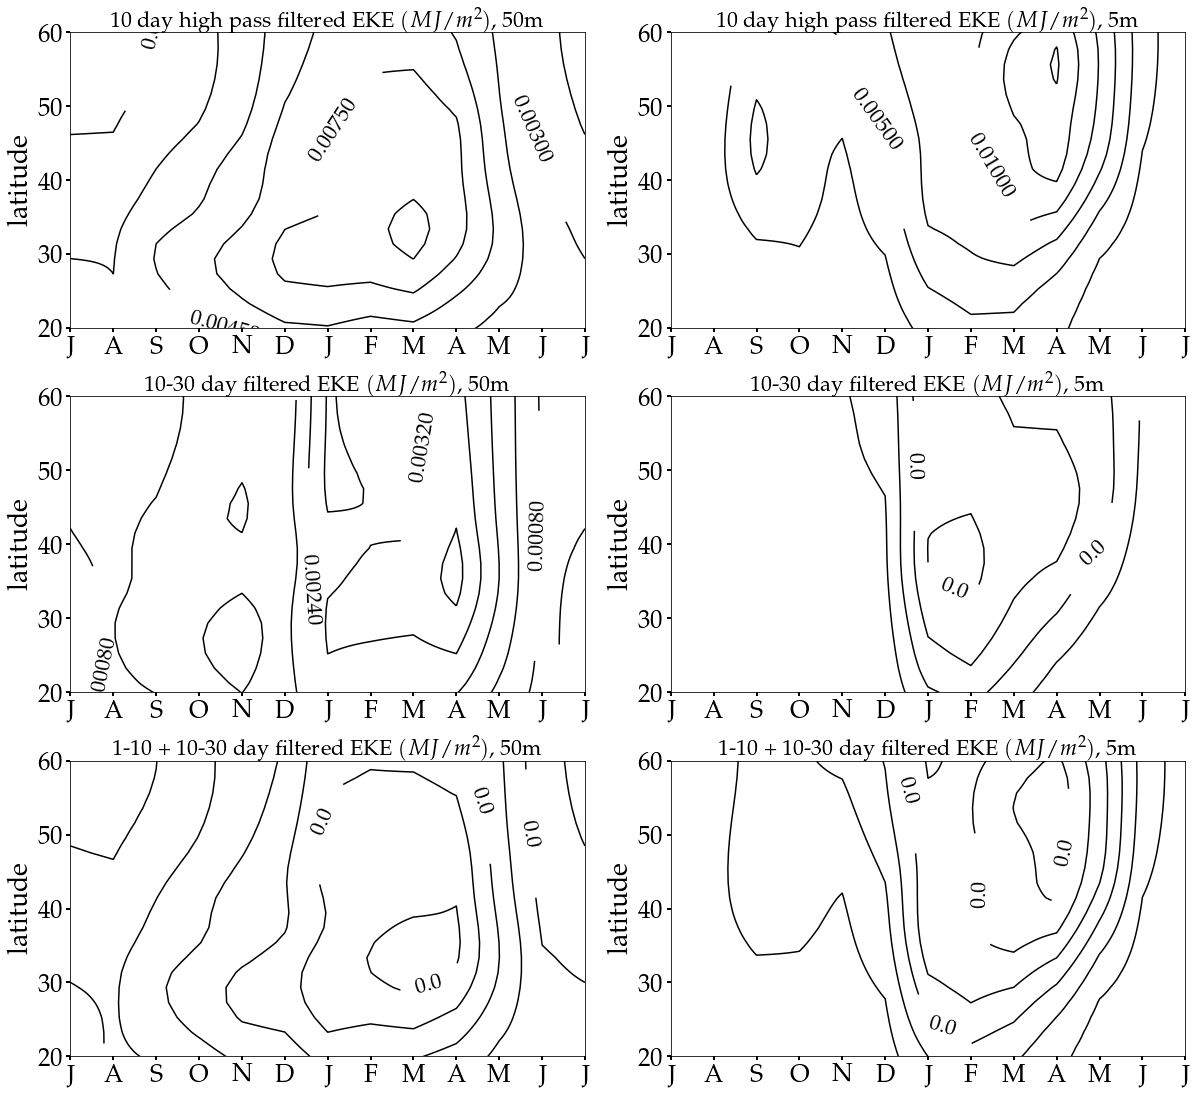

In [64]:

mticks = np.roll(np.array(['J','F','M','A','M','J','J','A','S','O','N','D','J']),6)
mticks2 = (np.array(['J','A','S','O','N','D', 'J','F','M','A','M','J','J']))

depths=['5m', '50m']

def roll(x):
    y=np.roll(x[...,:-1],6,axis=-1)
    return np.append(y, y[...,0,None],axis=-1)
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

py.figure(figsize=(25,25))
NN = 6
# loc=loc-1
d=1
loc=22
n=0;
sumi  = vert_EKEa/10**6
py.subplot(5,3,1)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.5f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10 day high pass filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,2)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.5f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10 day high pass filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

sumi  = EKE_Ia/10**6
d=1
n=0;
py.subplot(5,3,4)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.5f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,5)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'10-30 day filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)
# py.savefig('Sep8_Figures/high_filtered_TE.pdf')

sumi  = (EKE_Ia+EKE_Ha)/10**6
d=1
n=0;
py.subplot(5,3,7)
# py.contourf(range(13), lat_a, roll(EKEv_a[d,:,loc,:]),cmap=cm.plasma); 
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN,colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'1-10 + 10-30 day filtered EKE $(MJ/m^2)$, '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)

d=0
py.subplot(5,3,8)
# py.contourf(range(13), lat_a, roll(TEv_a[d,:,loc,:]),cmap=rcmap(cm.RdBu)); #py.colorbar()
c=py.contour(range(13), lat_a, roll(sumi[d,:,loc,:]),NN, colors='k'); #py.colorbar()
py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=10,fontsize=22)
py.xticks(range(13), (mticks2),fontsize=15)
py.ylim(20,60)
py.xticks(range(13), (mticks2),fontsize=15)
py.tick_params(labelsize=25,size=4,width=2)
py.title(r'1-10 + 10-30 day filtered EKE $(MJ/m^2)$,  '+str(depths[d]),fontsize=22)
py.ylabel('latitude',fontsize=27)


py.tight_layout()

In [52]:
# py.figure(figsize=(15,4))
# py.subplot(1,2,1)
# py.contourf(range(13),lat_a,TEsensv_a[0,...]/10**15, vmin=0,cmap=cm.Reds); py.colorbar()
# py.plot(range(13), storm_pos[0,:], 'wo-')
# py.subplot(1,2,2)
# py.contourf(range(13),lat_a,TEsensv_a[1,...]/10**15, vmin=0,cmap=cm.Reds); py.colorbar()
# py.plot(range(13), storm_pos[1,:], 'wo-')

In [53]:
# m=m+1
# py.plot(lat_a, TEsensv_a[1,:,m]/10**15,'r-')
# py.plot(lat_a, TEmoistv_a[1,:,m]/10**15,'b-')
# py.plot(lat_a, TEpotv_a[1,:,m]/10**15,'g-')
# py.plot(lat_a, TE_a[1,:,m],'k-')
# print m

In [54]:
# m=0
# py.plot(lat_a, TEsensv_a[0,:,m]/10**15,'r-')
# py.plot(lat_a, TEmoistv_a[0,:,m]/10**15,'b-')
# py.plot(lat_a, TEpotv_a[0,:,m]/10**15,'g-')

In [56]:
# Ihigh = inerp_at_max(flux=TE_a,lat=lat_a)

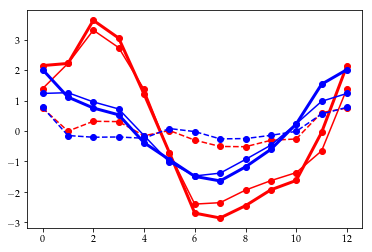

In [57]:
d=0
py.plot(range(13), Itotal[d,:]-Itotal[d,:-1].mean(), 'ro-', lw=3)
py.plot(range(13), Ihigh[d,:]-Ihigh[d,:-1].mean(), 'ro-')
py.plot(range(13), Iinter[d,:]-Iinter[d,:-1].mean(), 'ro--')

d=1
py.plot(range(13), Ihigh[d,:]-Ihigh[d,:-1].mean(), 'bo-')
py.plot(range(13), Iinter[d,:]-Iinter[d,:-1].mean(), 'bo--')
py.plot(range(13), Itotal[d,:]-Itotal[d,:-1].mean(), 'bo-', lw=3)
